**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_1_)    
      - [Importing Python Libraries](#toc1_1_1_1_)    
      - [Loading Clean Dataset](#toc1_1_1_2_)    
    - [Merge Early Reviews with Meta data](#toc1_1_2_)    
    - [Logistic Regression](#toc1_1_3_)    
      - [Hyper parameter tuning](#toc1_1_3_1_)    
      - [Model Evaluation](#toc1_1_3_2_)    
      - [Model Coefficients](#toc1_1_3_3_)    
    - [Model Comparison with and without early reviews](#toc1_1_4_)    
    - [Conclusion](#toc1_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction](#toc0_)

In this notebook, we incorporate early reviews specifically first 5 reviews of products and build a Logistic Regression model to predict popularity. 
We also evaluate and compare model performance to model using the meta data only.  

#### <a id='toc1_1_1_1_'></a>[Importing Python Libraries](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import  SelectKBest, chi2
from sklearn.utils import resample
import string
import spacy

# Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Useful settings

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set matplotlib global settings eg. figsize
sns.set_style("white")                   #Setting grid style in seaborn


#### <a id='toc1_1_1_2_'></a>[Loading Clean Dataset](#toc0_)

In [3]:
# Here we load the preprocessed DataFrame that contains the necessary columns for modeling
meta_df = pd.read_pickle('../data/meta_sample_preprocessed.pkl')
meta_df.head()

,product_title,average_rating,rating_number,product_price,store,parent_asin,all_subcategories,date_first_available,bayesian_rating,is_popular,...,subcategory1_rating_mean,subcategory1_rating_std,combined_category_rating_mean,combined_category_product_counts,combined_category_rating_std,log_combined_category_product_counts,subcategory1_rating_cv,combined_category_rating_cv,subcategory1_target_encoded,combined_category_target_encoded
0,Sterling Silver Hammered Ear Cuff,4.4,243,24.00,twisted designs jewelry,B0178HXZUY,Jewelry Earrings Ear Cuff,2015-10-27,4.407956,0,...,4.442259,0.155776,4.451759,2899,0.151968,7.972466,0.035067,0.034137,0.410765,0.433598
1,"Humorous Cat Wall Art - Decor for Home, Office...",4.5,108,12.95,yellowbird art & design,B07ZFJXDH8,Home & Kitchen Artwork Prints,2019-11-05,4.496569,0,...,4.495776,0.138751,4.488320,7350,0.140358,8.902592,0.030863,0.031272,0.553306,0.523537
2,Whiskey Glasses by Black Lantern – Floral Whis...,4.4,11,31.00,black lantern,B089LRPX7X,Home & Kitchen Dining Tableware Glassware Tumb...,2016-01-26,4.457846,0,...,4.495776,0.138751,4.518841,1839,0.128856,7.517521,0.030863,0.028515,0.553306,0.613921
3,LOVE Dog Paw Print Heart Sticker Decal Compati...,4.1,3,3.99,generic,B01MXKS1L5,Electronics Accessories Laptop Skins & Decals,2016-11-14,4.442769,0,...,4.471043,0.141498,4.508194,206,0.139531,5.332719,0.031648,0.030951,0.481562,0.592233
4,"Bachelorette Party Shirts, Soft Crew Neck and ...",4.6,64,15.59,patyz,B07Q5VXBCC,Clothing Shoes & Accessories Men Tops Tees T-S...,2019-03-30,4.566003,1,...,4.490060,0.131767,4.479571,1147,0.122598,7.045777,0.029346,0.027368,0.524289,0.471665


In [4]:
#Here we load the dataframe containing early reviews of products
early_df = pd.read_pickle('../data/early_reviews.pkl')
early_df.head()

,parent_asin,early_rating_avg,early_verified_ratio,early_sentiment,early_review_title_word_counts,early_review_text_word_counts
0,B001RMKWM6,3.6,0.6,0.26130,2.8,56.8
1,B0155Y8RQY,5.0,1.0,0.71510,2.6,14.8
2,B0157CCJ7C,4.8,1.0,0.81328,3.8,15.6
3,B0158SFDUA,5.0,1.0,0.90284,2.4,22.8
4,B01591IOQG,5.0,0.8,0.88314,3.6,39.6


### <a id='toc1_1_2_'></a>[Merge Early Reviews with Meta data](#toc0_)

In [5]:
model_df = pd.merge(meta_df, early_df, on='parent_asin')

# Display the first few rows of the merged DataFrame
model_df.head()

,product_title,average_rating,rating_number,product_price,store,parent_asin,all_subcategories,date_first_available,bayesian_rating,is_popular,...,log_combined_category_product_counts,subcategory1_rating_cv,combined_category_rating_cv,subcategory1_target_encoded,combined_category_target_encoded,early_rating_avg,early_verified_ratio,early_sentiment,early_review_title_word_counts,early_review_text_word_counts
0,Sterling Silver Hammered Ear Cuff,4.4,243,24.00,twisted designs jewelry,B0178HXZUY,Jewelry Earrings Ear Cuff,2015-10-27,4.407956,0,...,7.972466,0.035067,0.034137,0.410765,0.433598,5.0,1.0,0.71950,3.8,22.6
1,1 Inch Pet T-Rex in Glass Round Jar Green with...,4.5,285,24.99,fish belli,B071YX28MP,Toys & Games Dolls Toy Figures Accessories,2016-10-01,4.498522,0,...,3.828641,0.038811,0.046229,0.544850,0.466667,5.0,0.8,0.81748,4.2,31.4
2,Bounty Hunter Star Mandalorian Logo Mudhorn Si...,4.9,276,8.99,generic,B083D6TS21,Stationery & Party Supplies Stickers,2020-01-01,4.864041,1,...,8.058960,0.027784,0.027784,0.609301,0.609301,5.0,1.0,0.82028,3.2,12.8
3,"Tiny 3MM White Moissanite Diamond Earrings, St...",4.6,122,28.00,6grape,B07MZB3SD4,Jewelry Earrings Stud,2022-05-30,4.579326,1,...,7.972466,0.035067,0.034137,0.410765,0.433598,5.0,1.0,0.86662,5.2,22.4
4,Gold Plated Crescent Moon Stud Earrings,4.5,526,16.50,mjlulu,B01M4KL88J,Jewelry Earrings Stud,2016-10-17,4.499167,0,...,7.972466,0.035067,0.034137,0.410765,0.433598,5.0,1.0,0.86664,4.4,17.0


In [6]:
#Drop columns that are not required
model_df = model_df.drop(columns=['rating_number','average_rating','bayesian_rating','product_title','store_product_counts',
                                 'date_first_available','store','all_subcategories','combined_category','title_category',
                                 'product_price','combined_category_product_counts']).copy()

In [7]:
#Set parent_asin column as the index of dataframe
model_df.set_index('parent_asin', inplace=True)

In [8]:
model_df.columns

Index(['is_popular', 'num_product_images', 'product_features',
       'product_title_length', 'is_generic_store', 'log_store_product_counts',
       'store_rating_mean', 'store_rating_std', 'store_rating_cv',
       'store_size_tier', 'store_target_encoded', 'product_age_days',
       'is_weekend_release', 'log_price', 'subcategory1_rating_mean',
       'subcategory1_rating_std', 'combined_category_rating_mean',
       'combined_category_rating_std', 'log_combined_category_product_counts',
       'subcategory1_rating_cv', 'combined_category_rating_cv',
       'subcategory1_target_encoded', 'combined_category_target_encoded',
       'early_rating_avg', 'early_verified_ratio', 'early_sentiment',
       'early_review_title_word_counts', 'early_review_text_word_counts'],
      dtype='object')

In [9]:
#check if there are any missing values
model_df.isna().sum().loc[lambda x: x> 0]

Series([], dtype: int64)

### <a id='toc1_1_3_'></a>[Logistic Regression](#toc0_)

We follow a similar modeling procedure as the model with metadata, with the only addition being certain aggregated features (early review rating, early sentiment, verified purchase ratio) derived from the fist 5 reviews of products in the reviews dataset to train a logistic regression model. 

In [10]:
#lets prepare data for modeling

#Define features
X = model_df.drop(columns=['is_popular'])

#define target
y=model_df['is_popular']


In [11]:
#lets split the data into train and test before applying transformations

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, stratify = y,random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, stratify = y_remainder,random_state = 2)

print(X.shape)

(1868, 27)


In [12]:
#Define custom tokenizer for TF-IDF Vectorization of text data

import unicodedata

# Load the large English pipeline
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])  # Disabling parser & NER for efficiency

def normalize_text(text):
    """
    Normalizes text by converting special Unicode characters into standard ASCII.
    """
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return normalized_text

def custom_tokenizer(row):
    """
    Tokenizes and lemmatizes a product title, normalizing Unicode characters
    and removing stopwords.

    Args:
        row (str): A product title or description.

    Returns:
        str: Processed text with lemmatized words.
    """
    # Normalize Unicode styles
    normalized_text = normalize_text(row)

    # Process text with spacy
    parsed_title = nlp(normalized_text)

    # Extract only relevant tokens
    tok_lemmas = [
        token.lemma_.lower()    # Convert lemma to lowercase
        for token in parsed_title 
        if token.is_alpha       # Ensure token is alphabetic
        and not token.is_stop   # Remove stopwords
        and len(token) > 3      # Ignore very short words
        and token.pos_ in ("ADJ", "NOUN", "PROPN")  # Extract nouns and adjectives
    ]

    # Remove duplicates while preserving order
    unique_tokens = list(dict.fromkeys(tok_lemmas))

    return unique_tokens  # Convert list to a single string

In [13]:
#Build a pipeline to systematically apply all the transformations to the training data

# 1. Text Processing Pipeline
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=custom_tokenizer,  # Custom tokenizer to preprocess text
        lowercase=True,              # Convert all text to lowercase
        min_df=5,                    # Ignore terms that appear in fewer than 5 documents
        max_df=0.30,                 # Ignore terms that appear in more than 30% of documents
        stop_words='english'          # Remove common English stopwords
    )),
    ('feature_select', SelectKBest(chi2, k=500))  # Select top 500 features using Chi-square test
])

# 2. Identifying Numerical Columns (excluding categorical/text columns)
numerical_cols = X.drop(columns=['product_features', 'is_generic_store', 'store_size_tier', 'is_weekend_release']).columns

# 3. Full Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'product_features'),  # Process text column with the text pipeline
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['store_size_tier']),  # OHE for store size tier
    ('passthrough', 'passthrough', ['is_weekend_release','is_generic_store']),  # Keep columns as-is
    ('num', StandardScaler(), numerical_cols)  # Standardize numerical columns
])

# 4. Final Model Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessor
    ('classifier', LogisticRegression(max_iter=5000))  # Logistic Regression model
])

# 5. Fit Model & Evaluate Performance
pipeline.fit(X_train, y_train)
print(f"Train Accuracy: {pipeline.score(X_train, y_train):.4f}")
print(f"Val Accuracy: {pipeline.score(X_val, y_val):.4f}")

Train Accuracy: 0.8278
Val Accuracy: 0.7929


#### <a id='toc1_1_3_1_'></a>[Hyper parameter tuning](#toc0_)

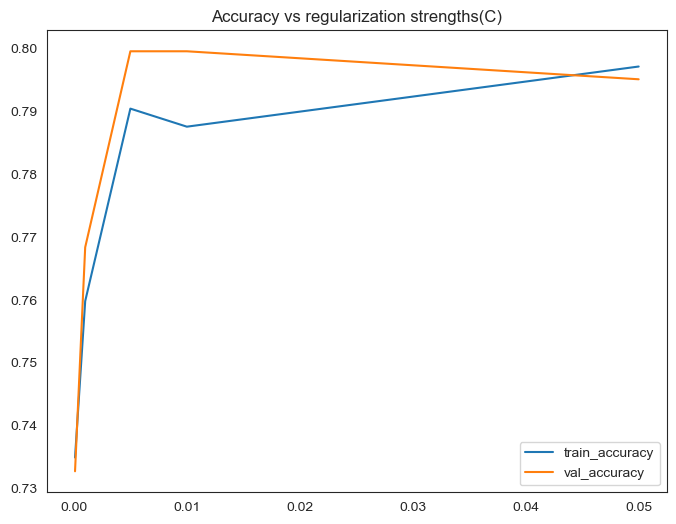

In [14]:
# Tune regularization in Logistic Regression 

train_accuracy = []
val_accuracy = []
param_range = [1e-4, 1e-3, 0.005, 0.01,0.05]

#Instantiate pipeline
pipe_loop = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', LogisticRegression(max_iter=5000)) 
])


for C_param in param_range:
        
    #Update parameter hyper-parameter for every iteration
    pipe_loop.set_params(classifier__C = C_param)    

    #Fit data
    pipe_loop.fit(X_train, y_train)

    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Accuracy vs regularization strengths(C)')
plt.legend()
plt.show()

We observe highest validation accuracy and minimal overfitting using C=0.01. Therefore we will retrain our model using C=0.01.

In [15]:
#Refitting Logreg with C=0.01

pipe_logreg_final  = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', LogisticRegression(C=0.01, max_iter=5000)) 
])

#Fit Pipeline
pipe_logreg_final.fit(X_train,y_train)
avg_cv_score = np.mean(cross_val_score(pipe_logreg_final, X_train,y_train,cv=5))

#Score
print(f' Train Accuracy of final model: {np.round(pipe_logreg_final.score(X_train,y_train),4)}')
print(f' Test Accuracy of final model: {np.round(pipe_logreg_final.score(X_test,y_test),4)}')


 Train Accuracy of final model: 0.7876
 Test Accuracy of final model: 0.7834


In [24]:
# Save the model
joblib.dump(pipe_logreg_final, '../models/logreg_early_reviews_model.pkl')

['../data/logreg_early_reviews_model.pkl']

#### <a id='toc1_1_3_2_'></a>[Model Evaluation](#toc0_)

Confusion matrices: 



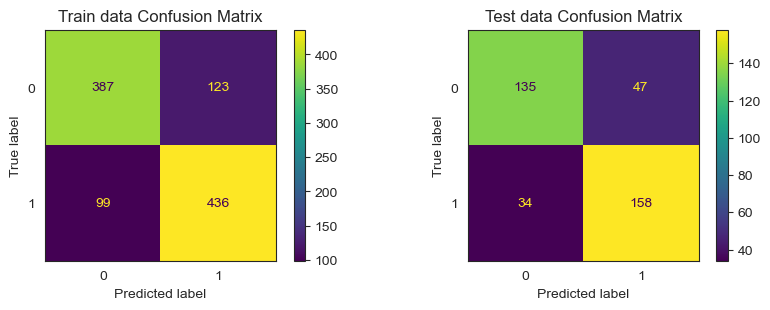


Train data classification report: 
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       510
           1       0.78      0.81      0.80       535

    accuracy                           0.79      1045
   macro avg       0.79      0.79      0.79      1045
weighted avg       0.79      0.79      0.79      1045


Test data classification report: 
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       182
           1       0.77      0.82      0.80       192

    accuracy                           0.78       374
   macro avg       0.78      0.78      0.78       374
weighted avg       0.78      0.78      0.78       374



In [16]:
#Make predictions
y_pred_train = pipe_logreg_final.predict(X_train)
y_pred_test = pipe_logreg_final.predict(X_test)

print_line = "\n=======================================================\n"
# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(pipe_logreg_final, X_train, y_train, ax=axes[0])
axes[0].set_title("Train data Confusion Matrix")

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(pipe_logreg_final, X_test, y_test, ax=axes[1])
axes[1].set_title("Test data Confusion Matrix")

plt.show()

# also saving the confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_pred_test),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)

# Classification Reports
print("\nTrain data classification report:", print_line, classification_report(y_train,y_pred_train))
print("\nTest data classification report:", print_line, classification_report(y_test,y_pred_test))

**Overall Performance**

- The model achieves similar (78%) accuracy on both the train and test sets, suggesting minimal overfitting

- Precision and recall scores for both classes are well-balanced, with an F1-score of 0.80 for the Popular class and 0.77 for the Unpopular class.

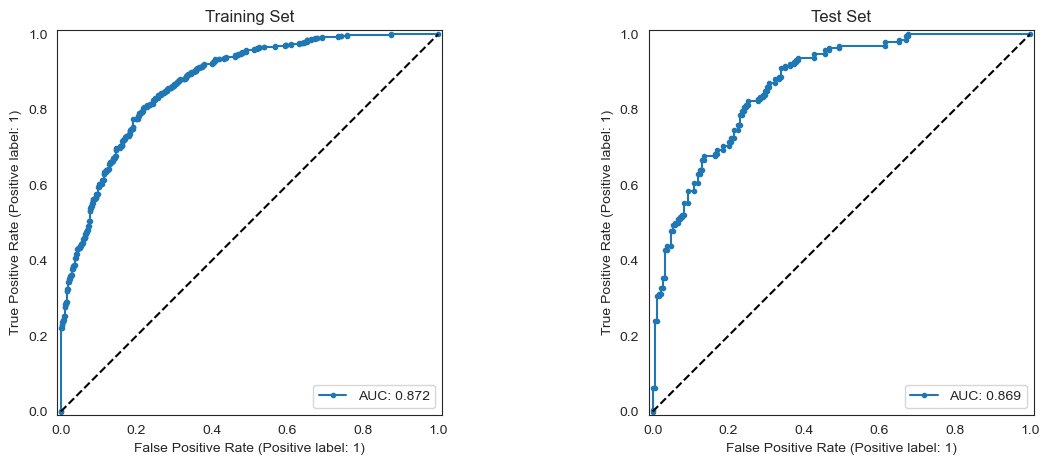

In [17]:
#Compute ROC-AUC curve for positive class

# Set up subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predict probabilities
y_proba_train = pipe_logreg_final.predict_proba(X_train)[:, 1]
y_proba_test = pipe_logreg_final.predict_proba(X_test)[:, 1]

# Score (AUC)
auc_train = np.round(roc_auc_score(y_train, y_proba_train), 3)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

# Labels
train_label = f"AUC: {auc_train}"
test_label = f"AUC: {auc_test}"

# Plot ROC curve

# Using RocCurveDisplay - pass in the fitted model, then the X data, then the y data
RocCurveDisplay.from_estimator(pipe_logreg_final, X_train, y_train, ax=axes[0], marker=".", label=train_label)
RocCurveDisplay.from_estimator(pipe_logreg_final, X_test, y_test, ax=axes[1], marker=".", label=test_label)

axes[0].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[0].set_title("Training Set")
axes[1].set_title("Test Set")

plt.show()

**ROC-AUC Score**: A ROC-AUC score of 0.87 indicates that there is a 87% chance that the model ranks a randomly chosen popular product higher than a randomly chosen unpopular product.

**Training vs.Test ROC-AUC**: ROC-AUC scores are very similar between the training and test data suggesting that the model is able to generalize well to unseen data.

#### <a id='toc1_1_3_3_'></a>[Model Coefficients](#toc0_)

In [18]:
# Put the variable names and their coefficient values into a data frame

#Get feature names from the ColumnTransformer
feature_names = pipe_logreg_final.named_steps['preprocessor'].get_feature_names_out()
#feature_names = X_train.columns

#Extract coefficients from the logistic regression model
coefficients = pipe_logreg_final.named_steps['classifier'].coef_[0]  

# Create the DataFrame to map feature names to coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

#Sort by absolute value of coefficients
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True, ignore_index=True)

coef_df_top20 = coef_df.head(20)  #display top 20 coefficients
coef_df_top20                    

,Feature,Coefficient,Abs_Coefficient
0,num__store_target_encoded,0.607753,0.607753
1,num__store_rating_mean,0.449180,0.449180
2,num__early_rating_avg,0.216907,0.216907
3,num__early_sentiment,0.182538,0.182538
4,num__combined_category_target_encoded,0.134077,0.134077
5,num__combined_category_rating_mean,0.132047,0.132047
6,passthrough__is_weekend_release,0.125357,0.125357
7,num__log_price,0.116119,0.116119
8,num__subcategory1_target_encoded,0.089249,0.089249
9,num__subcategory1_rating_mean,0.081440,0.081440


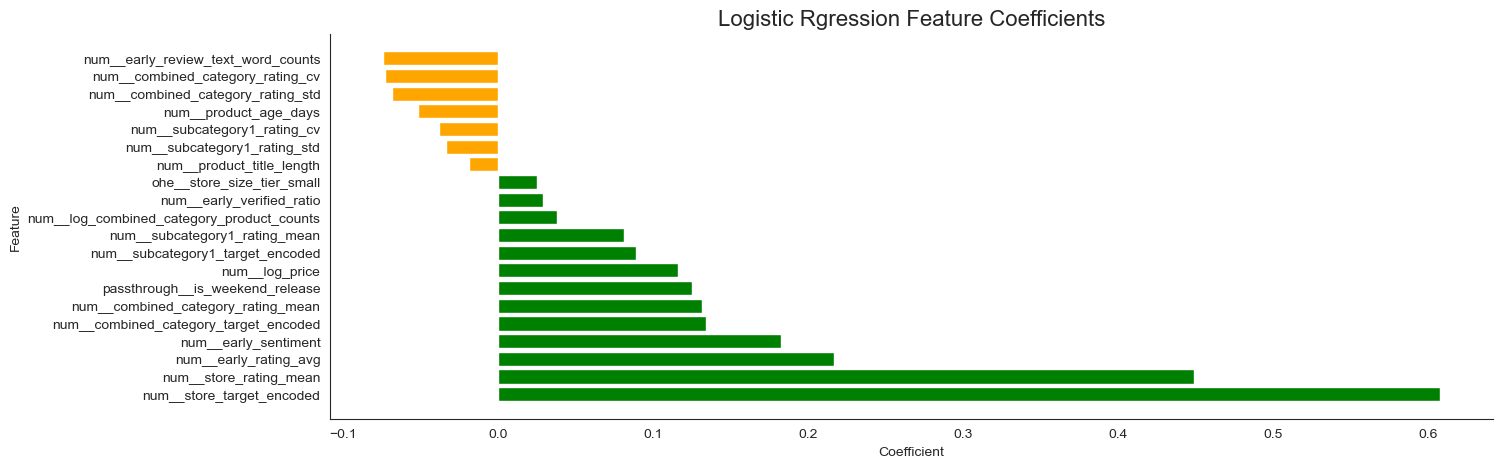

In [19]:
# Plotting Coefficients 
plt.figure(figsize=(15,5))

positive_coefs = coef_df_top20[coef_df_top20['Coefficient'] >=0]
negative_coefs = coef_df_top20[coef_df_top20['Coefficient'] < 0]

# Sort positive and negative coefficients in descending order
positive_coefs = positive_coefs.sort_values(by='Coefficient', ascending=False)
negative_coefs = negative_coefs.sort_values(by='Coefficient', ascending=False) 

plt.barh(positive_coefs['Feature'], positive_coefs['Coefficient'],color='green')
plt.barh(negative_coefs['Feature'], negative_coefs['Coefficient'],color='orange')

plt.title('Logistic Rgression Feature Coefficients', fontsize=16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.show()

### <a id='toc1_1_4_'></a>[Model Comparison with and without early reviews](#toc0_)

**Model Summary** on Class 1 (popular items) Test data
| |precision|recall|F1|ROC-AUC
|-|---------|------|--|------|
|**LogReg Meta data**|66%|72%|69%|74%
|**LogReg Meta data + Early Reviews**|77%|82%|80%|86%

**Model Summary** on Class 0 (unpopular items) Test data
| |precision|recall|F1|ROC-AUC
|-|---------|------|--|------|
|**LogReg Meta data**|68%|61%|65%|74%
|**LogReg Meta data + Early Reviews**|80%|74%|77%|86%

Incorporating early reviews significantly enhances the model’s ability to distinguish between popular and unpopular products. The model becomes more precise in identifying popular items while also improving recall, ensuring fewer truly popular products are misclassified. Similarly, for unpopular items, the model gains better precision and recall, making it more reliable in filtering out low-quality or less popular products. Overall, the addition of early review features strengthens class separation, reduces misclassifications, and leads to better predictions by the model.

**Feature Coefficients**

- As observed in the metadata-only model, the model tends to rely more on numerical features than text-based features.

- The top numerical features in the metadata model include store and category-based statistics of ratings and product counts, store size, number of product images, and product price. 

- When incorporating early reviews, aggregated review-based features such as review sentiment, verified purchase ratio, and mean review score emerge as additional key drivers of model performance.


### <a id='toc1_1_5_'></a>[Conclusion](#toc0_)

We fitted a Logistic Regression model using features from product metadata and the first five reviews, then evaluated its performance. The model showed a significant improvement compared to the metadata-only approach, suggesting that early reviews play a crucial role in predicting a product’s long-term success on Amazon.